# Paper figures

## Import libraries

In [37]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import yaml

## Load data

Should be located in `../data/`

In [2]:
df = pd.DataFrame()
for repository in ["zenodo", "figshare", "osf"]:
    datasets = pd.read_csv(
        f"../data/{repository}_datasets.tsv",
        sep="\t",
        dtype={"dataset_id": str}
    )
    print(f"{repository}: found {datasets.shape[0]} datasets.")
    files = pd.read_csv(
        f"../data/{repository}_files.tsv",
        sep="\t",
        dtype={"dataset_id": str, "file_type": str,
               "file_md5": str, "file_url": str}
    )
    print(f"{repository}: found {files.shape[0]} files.")
    tab = pd.merge(files, datasets, how="left", on=["dataset_id", "dataset_origin"], validate="many_to_one")
    print(f"{repository}: merged dataframe has {tab.shape[0]} entries.")
    df = pd.concat([df, tab], ignore_index=True)
print(f"Dimensions of the final dataframe: {df.shape[0]} lines (files) x {df.shape[1]} columns")

zenodo: found 958 datasets.
zenodo: found 137236 files.
zenodo: merged dataframe has 137236 entries.
figshare: found 892 datasets.
figshare: found 62391 files.
figshare: merged dataframe has 62391 entries.
osf: found 63 datasets.
osf: found 6056 files.
osf: merged dataframe has 6056 entries.
Dimensions of the final dataframe: 205683 lines (files) x 18 columns


### Assign year

In [3]:
df["year"] = df["date_creation"].apply(lambda x: int(x[:4]))

### Assign MD engine

In [4]:
file_types_list = []
with open("../params/file_types.yml", "r") as param_file:
    data_loaded = yaml.safe_load(param_file)
    file_types_list = data_loaded["file_types"]

    ext_gromacs = []
ext_namd = []
ext_amber = []
ext_charmm = []
ext_desmond = []

list_coordinate = []
list_trajectory = []
list_topology = []

for type_dict in file_types_list:
    # assign MD engine
    if type_dict["engine"] == "gromacs":
        ext_gromacs.append(type_dict["type"])
    elif type_dict["engine"] == "namd":
        ext_namd.append(type_dict["type"])
    elif type_dict["engine"] == "amber":
        ext_amber.append(type_dict["type"])
    elif type_dict["engine"] == "charmm":
        ext_charmm.append(type_dict["type"])
    elif type_dict["engine"] == "desmond":
        ext_desmond.append(type_dict["type"])
    # assign file category
    if type_dict["category"] == "coordinate":
        list_coordinate.append(type_dict["type"])
    elif type_dict["category"] == "topology":
        list_topology.append(type_dict["type"])
    elif type_dict["category"] == "trajectory":
        list_trajectory.append(type_dict["type"])

ext_all = ext_gromacs + ext_namd + ext_amber + ext_charmm
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

def assign_md_engine(file_type):
    """Assign MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "GROMACS"
    elif file_type in (ext_namd + ext_charmm):
        return "NAMD/CHARMM"
    elif file_type in ext_amber:
        return "AMBER"
    elif file_type in ext_desmond:
        return "DESMOND"
    else:
        return "None"

df["MD_engine"] = df["file_type"].apply(assign_md_engine)

Number of datasets and files per MD engine:

In [5]:
df.groupby("MD_engine").agg({"dataset_id": ["nunique", "count"]})

dataset_id        
               nunique   count
MD_engine                     
AMBER              216    8848
DESMOND             49    1869
GROMACS           1200   68200
NAMD/CHARMM        647   12041
None              1107  114725

### Assign category

In [6]:
def assign_file_category(file_type):
    """Assign file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

df["category"] = df["file_type"].apply(assign_file_category)
df["category"].value_counts()

none          143593
trajectory     34539
topology       20859
coordinate      6692
Name: category, dtype: int64

## Figure 1

Evolution of number of “molecular dynamics + simulation” papers in PubMed vs time

## Figure 2

### 2.B. Evolution of the number MD files deposited in data repositories

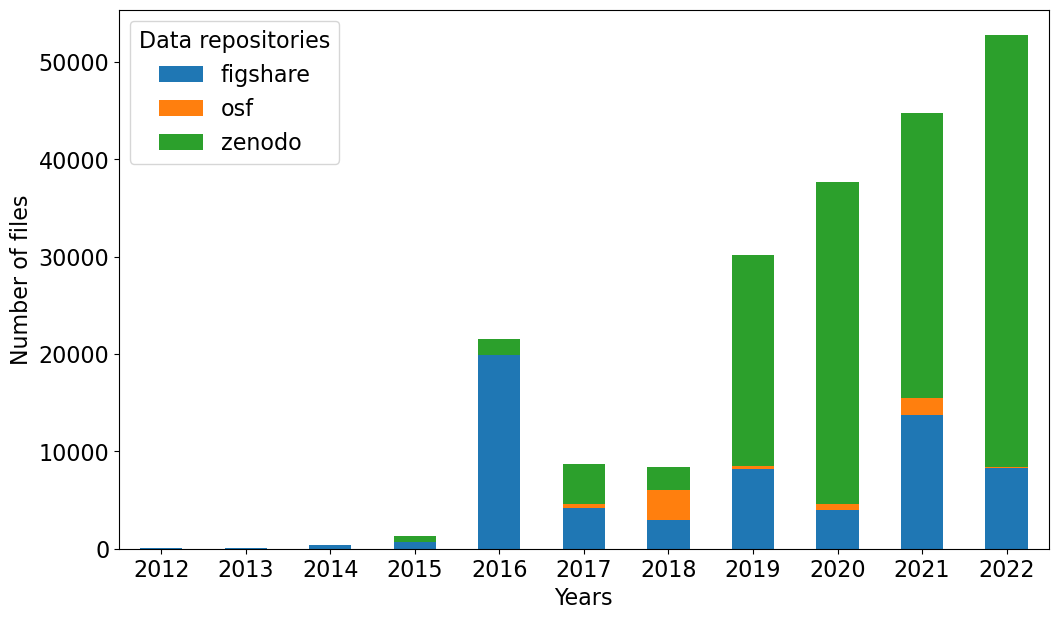

In [7]:
plt.rcParams.update({'font.size': 16})
(df
 .query("year != 2023")
 .query("year >= 2012")
 .groupby(["year", "dataset_origin"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="Data repositories")
plt.savefig("fig/number_of_files_per_years_per_data_repositories.png", dpi=300, bbox_inches="tight")
plt.savefig("fig/number_of_files_per_years_per_data_repositories.svg", bbox_inches="tight")

### 2.B. MD engines distribution

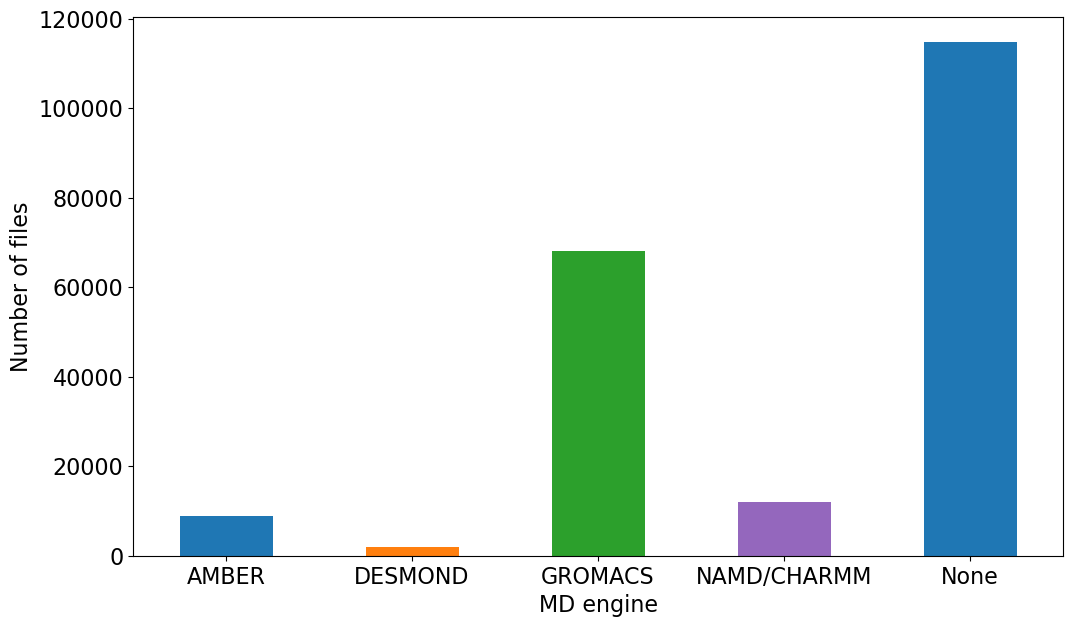

In [8]:
plt.rcParams.update({'font.size': 16})
(df
 .loc[:, "MD_engine"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple"], figsize=(12,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("fig/number_of_files_per_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("fig/number_of_files_per_MD_engine.svg", bbox_inches="tight")

### 2.C. Type of files not associated to any MD engine

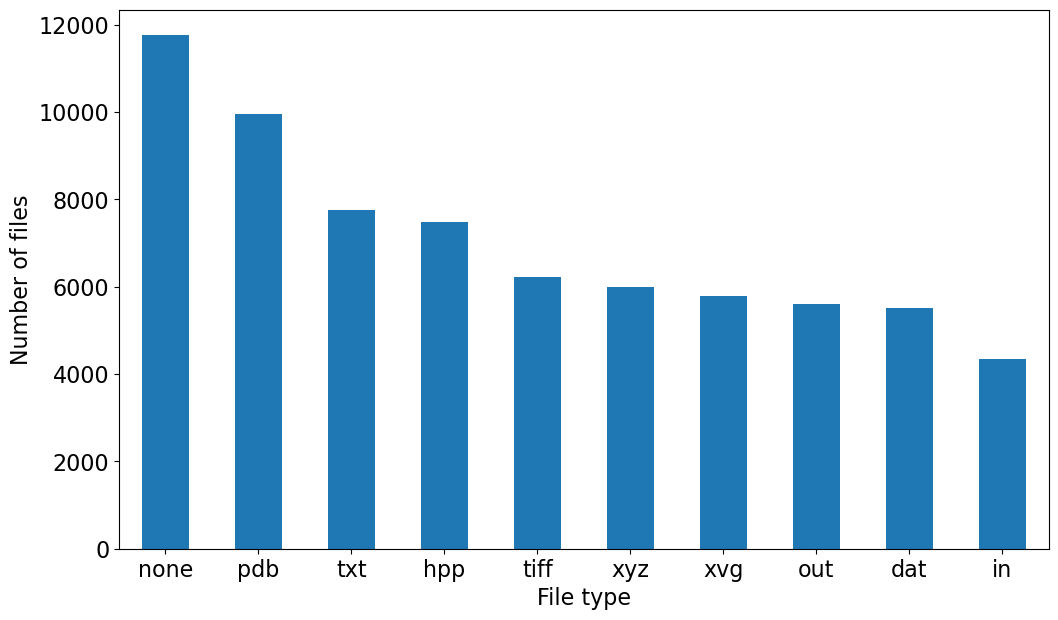

In [45]:
plt.rcParams.update({'font.size': 16})
(df
 .query("MD_engine == 'None'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="tab:blue", figsize=(12,7))
)
plt.xlabel("File type")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("fig/number_of_files_per_filetype_no_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("fig/number_of_files_per_filetype_no_MD_engine.svg", bbox_inches="tight")

### 3.A. Gromacs file types by categories

10 most frequent Gromacs file types

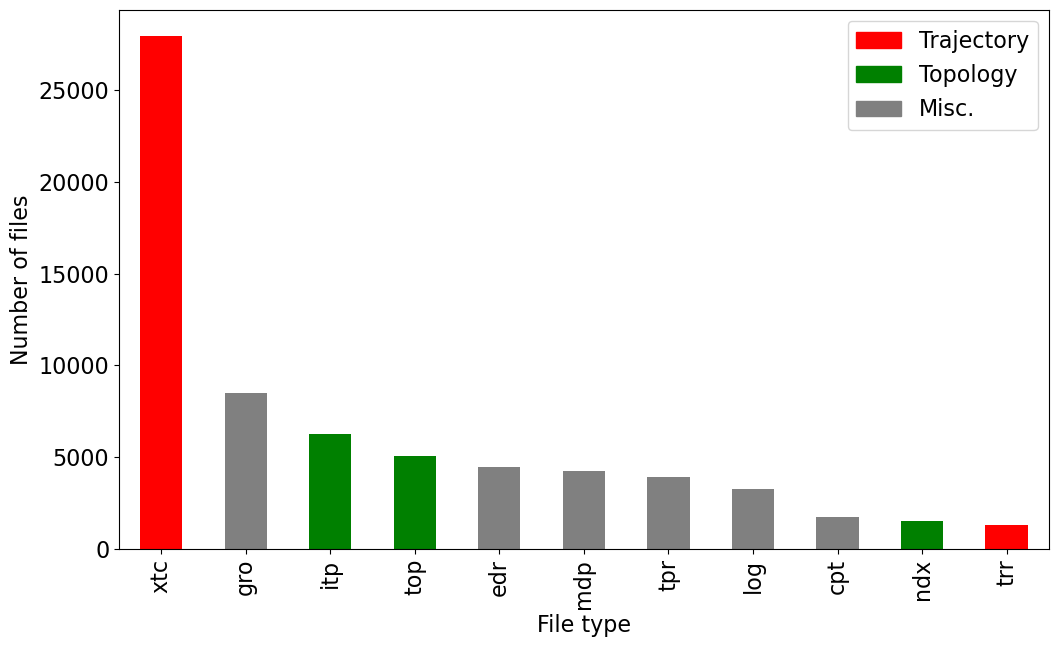

In [44]:
colors={
    "trajectory":"red",
    "topology":"green",
    "none":"grey"
}
gromacs_file_types = (df
 .query("MD_engine == 'GROMACS'")
 .groupby("file_type").agg({"category": "first", "file_name": "count"})
 .sort_values(by="file_name", ascending=False)
)
plt.rcParams.update({'font.size': 16})
gromacs_file_types["color"] = gromacs_file_types["category"].map(colors)
gromacs_file_types.plot(kind="bar", y="file_name", figsize=(12,7), color=gromacs_file_types["color"])
plt.xlabel("File type")
plt.ylabel("Number of files")
# Custom legend.
traj_patch = mpatches.Patch(color="red", label="Trajectory")
topol_patch = mpatches.Patch(color="green", label="Topology")
misc_patch = mpatches.Patch(color="grey", label="Misc.")
plt.legend(handles=[traj_patch, topol_patch, misc_patch])
plt.savefig("fig/number_of_files_per_filetype_no_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("fig/number_of_files_per_filetype_no_MD_engine.svg", bbox_inches="tight")

### 3.B. Cumulated distribution of gro files